In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Import data as a dataframe

freestyle = pd.read_csv('speedrun_data.csv')

#Reorganize indexes
# speed_df.set_index(['Star Rating','Monster Name'],inplace=True)

freestyle.head()

,Star Rating,Monster Name,Quest,Runner,Time,Weapon,Platform,Ruleset
0,6,Alatreon,The Evening Star,DEVA,"01'55""11",Heavy Bowgun,PC,Freestyle
1,6,Alatreon,The Evening Star,DEVA,"02'05""13",Heavy Bowgun,PC,Freestyle
2,6,Alatreon,The Evening Star,Jackdaw갈까마귀,"02'24""56",Heavy Bowgun,PC,Freestyle
3,6,Alatreon,The Evening Star,Jackdaw갈까마귀,"02'30""96",Heavy Bowgun,PC,Freestyle
4,6,Alatreon,Dawn of the Death Star,Jackdaw갈까마귀,"02'44""40",Heavy Bowgun,PC,Freestyle


In [3]:
# Filter out 'repeat runs'
# 'Repeat run': run on the same monster, same quest, by the same runner with the same weapon, but different times.
# Keep only the fastest run

freestyle = freestyle.drop_duplicates(['Monster Name','Quest','Runner','Weapon'],keep='first') #Already sorted by time,
                                                                                               #first time = fastest!
freestyle

,Star Rating,Monster Name,Quest,Runner,Time,Weapon,Platform,Ruleset
0,6,Alatreon,The Evening Star,DEVA,"01'55""11",Heavy Bowgun,PC,Freestyle
2,6,Alatreon,The Evening Star,Jackdaw갈까마귀,"02'24""56",Heavy Bowgun,PC,Freestyle
4,6,Alatreon,Dawn of the Death Star,Jackdaw갈까마귀,"02'44""40",Heavy Bowgun,PC,Freestyle
5,6,Alatreon,The Evening Star,Relial,"02'47""35",Heavy Bowgun,PC,Freestyle
7,6,Alatreon,Dawn of the Death Star,Relial,"02'58""53",Heavy Bowgun,PC,Freestyle
...,...,...,...,...,...,...,...,...
8225,1,Tzitzi-Ya-Ku,All the Wrong Signals,Lumini,"03'16""23",Hunting Horn,PS4,Freestyle
8226,1,Tzitzi-Ya-Ku,All the Wrong Signals,CBonduMiel,"03'37""48",Great Sword,PC,Freestyle
8227,1,Tzitzi-Ya-Ku,All the Wrong Signals,shakybake,"04'12""08",Sword And Shield,PC,Freestyle
8228,1,Tzitzi-Ya-Ku,All the Wrong Signals,Unsafekibble,"04'57""73",Great Sword,PS4,Freestyle


In [4]:
#Function to convert the time field to seconds
def to_seconds(time_string):
    
    #Get minutes, seconds and centi seconds from string
    minutes = int(time_string[0:2])
    seconds = int(time_string[3:5])
    cents = int(time_string[6:])
    
    #Return total in seconds
    return 60*minutes+seconds+cents/100
    
#Add Time (Seconds) column
freestyle.insert(5, 'Time (Seconds)', freestyle['Time'].apply(to_seconds))

In [5]:
#Convert Star Rating to string (discrete values!)
freestyle['Star Rating']=freestyle['Star Rating'].apply(str)

In [6]:
#Abbreviate weapon names

weapon_dict = {'Great Sword':'GS',
               'Long Sword':'LS',
               'Sword And Shield':'SnS',
               'Dual Blades':'DB',
               'Lance':'Lance',
               'Gunlance':'GL',
               'Hammer':'Hammer',
               'Hunting Horn':'HH',
               'Switch Axe':'SA',
               'Charge Blade':'CB',
               'Insect Glaive':'IG',
               'Heavy Bowgun':'HBG',
               'Light Bowgun':'LBG',
               'Bow':'Bow'    
               }

#Apply dict to weapons column
freestyle['Weapon']=freestyle['Weapon'].apply(lambda x: weapon_dict[x])

In [7]:
# Sort dataframe by, in order: Star Rating, Monster Name, Quest, and Time
freestyle = freestyle.sort_values(['Star Rating','Monster Name','Quest','Time (Seconds)'],ascending=[False,True,True,True])

In [8]:
# Separate TA runs. Note that Freestyle runs also encompass TA runs (ie a TA run is also a Freestyle run, but a Freestyle run
# not be a TA run)

ta = freestyle[freestyle['Ruleset']=='TA Rules'].copy()
ta = ta.drop('Ruleset',axis=1) #Drop Ruleset column as it is redundant

In [9]:
#Very early analysis: just get average clear time by weapons

avg_freestyle = freestyle.groupby('Weapon').mean().reset_index()
avg_ta = ta.groupby('Weapon').mean().reset_index()

#Sort
avg_freestyle = avg_freestyle.sort_values('Time (Seconds)',ascending=True)
avg_ta = avg_ta.sort_values('Time (Seconds)',ascending=True)

<AxesSubplot:xlabel='Weapon', ylabel='Time (Seconds)'>

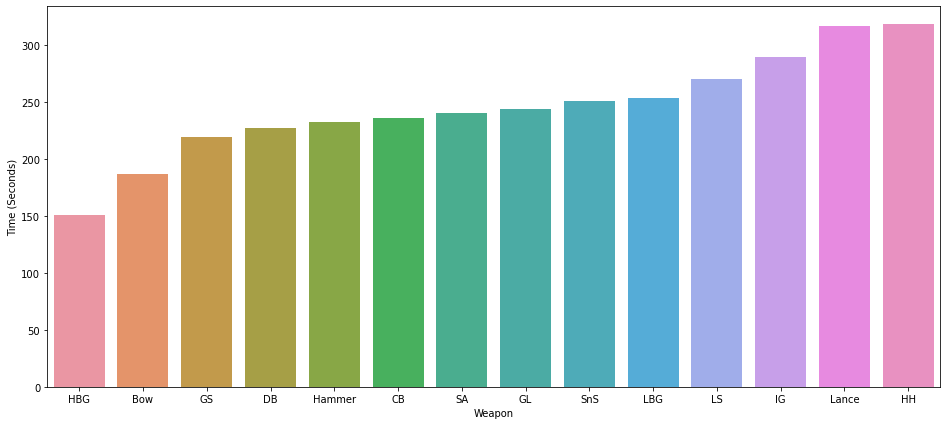

In [10]:
#Plot average freestyle times
plt.figure(figsize=(16,7))
sns.barplot(x='Weapon',y='Time (Seconds)',data=avg_freestyle)

In [11]:
avg_freestyle

,Weapon,Time (Seconds)
5,HBG,150.612333
0,Bow,186.930182
4,GS,218.979178
2,DB,227.115677
7,Hammer,232.012903
1,CB,235.929221
12,SA,240.311635
3,GL,243.423017
13,SnS,250.221685
9,LBG,253.002109


<AxesSubplot:xlabel='Weapon', ylabel='Time (Seconds)'>

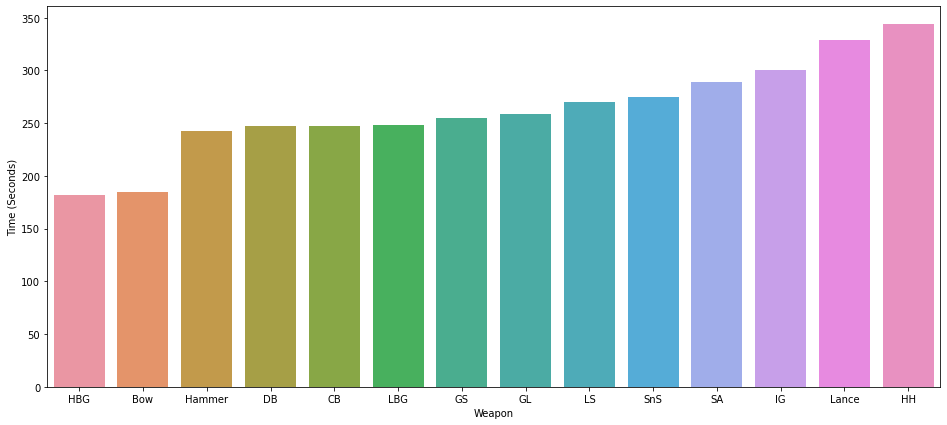

In [12]:
#Plot average TA times
plt.figure(figsize=(16,7))
sns.barplot(x='Weapon',y='Time (Seconds)',data=avg_ta)

In [13]:
avg_ta

,Weapon,Time (Seconds)
5,HBG,182.215044
0,Bow,184.636497
7,Hammer,242.781013
2,DB,246.756704
1,CB,247.118171
9,LBG,248.360052
4,GS,254.508763
3,GL,258.155238
10,LS,269.803599
13,SnS,274.909124
